# Tutorial of the calculation of the return period curve of a climatic driver descriptor

In [29]:
# Python 2/3 setup 
from __future__ import (absolute_import, division, print_function, unicode_literals)
# from builtins import *

In [30]:
# Juypyter setup

#import matplotlib
#matplotlib.use('nbagg')

%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Import Packages

In [31]:
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
import statsmodels.api as sm

from matplotlib import pyplot as plt
plt.style.use('bmh')

from climate import read
from climate import summary
from climate.stats import extremal
from scipy.stats import kstest
from scipy.stats import genpareto
from scipy.stats import genextreme
from climate.stats import empirical_distributions
from random import sample

In [32]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 5)
fig_x_size = 20
fig_y_size = 10

## Read SIMAR file

In [33]:
data_file = 'SIMAR_1052046'
full_data_path = os.path.join('..', '..', '..', '..', 'data', 'simar')
data_simar, code = read.simar(data_file, path=full_data_path)
data_simar

,Hm0,Tp,DirM,VelV,DirV
AA_MM_DD_HH,,,,,
1958-01-04 00:00:00,2.1,10.8,249.0,7.9,172.0
1958-01-04 01:00:00,2.1,10.6,250.0,7.5,170.0
1958-01-04 02:00:00,2.1,10.6,251.0,7.1,169.0
1958-01-04 03:00:00,2.1,10.6,252.0,6.7,167.0
1958-01-04 04:00:00,2.1,10.6,253.0,6.3,162.0
...,...,...,...,...,...
2017-08-06 20:00:00,0.6,9.7,287.0,4.2,301.0
2017-08-06 21:00:00,0.6,9.7,286.0,4.1,288.0
2017-08-06 22:00:00,0.6,9.7,286.0,3.1,269.0


## Input

In [34]:
data_column = 'Hm0'
threshold = np.percentile(data_simar[data_column], 95)
minimum_interarrival_time = pd.Timedelta('3 days')
minimum_cycle_length = pd.Timedelta('3 hours')
interpolation=True
interpolation_method = 'linear'
interpolation_freq = '1min'
truncate=False
extra_info = False
n_boot_sim = 1000
threshold

2.4

## Cycles calculation

In [35]:
# Storm cycles calculation
cycles, calm_periods = extremal.extreme_events(data_simar, data_column, threshold, minimum_interarrival_time,
                                               minimum_cycle_length, interpolation, interpolation_method,
                                               interpolation_freq, truncate, extra_info)

# Peaks over threshold calculations
peaks_over_thres = extremal.events_max(cycles)

In [36]:
# Save to csv
peaks_over_thres.to_csv('Picos_sobre_umbral.csv', sep=str(u'\t').encode('utf-8'))

## Empirical distribution

In [37]:
ecdf_pot = empirical_distributions.ecdf_histogram(peaks_over_thres)

In [38]:
# Calculate the return period curve

n_pot_anio = len(peaks_over_thres)/len(data_simar[data_column].index.year.unique())
ecdf_pot_hor_rp = 1/(n_pot_anio*(1-ecdf_pot))

## Method 1: Fit peaks over threshold to Generalized Pareto Distribution using Python

In [39]:
(param, x_gpd, y_gpd, y_gpd_rp) = extremal.extremal_distribution_fit(data=data_simar, var_name='Hm0',
                                                                     sample=peaks_over_thres,
                                                                     threshold=threshold, fit_type='gpd',
                                                                     x_min=0.90*min(peaks_over_thres),
                                                                     x_max=1.5*max(peaks_over_thres),
                                                                     n_points=1000,
                                                                     cumulative=True)

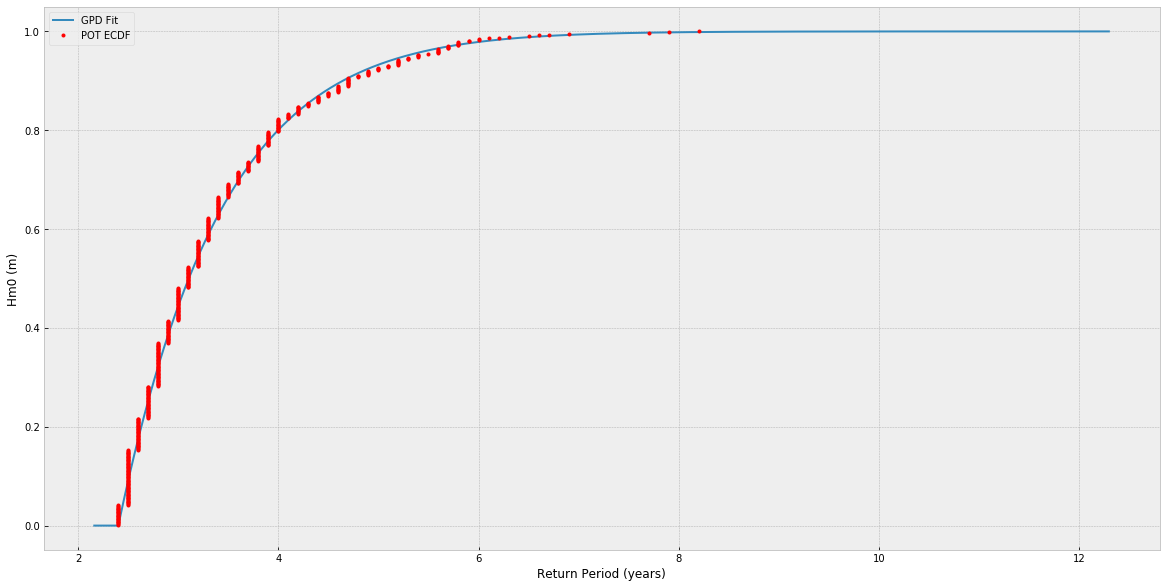

In [40]:
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()
ax.plot(x_gpd, y_gpd)
ax.plot(ecdf_pot.index, ecdf_pot, '.r')
plt.xlabel('Return Period (years)')
plt.ylabel('Hm0 (m)')
ax.legend(['GPD Fit', 'POT ECDF'])
plt.show()

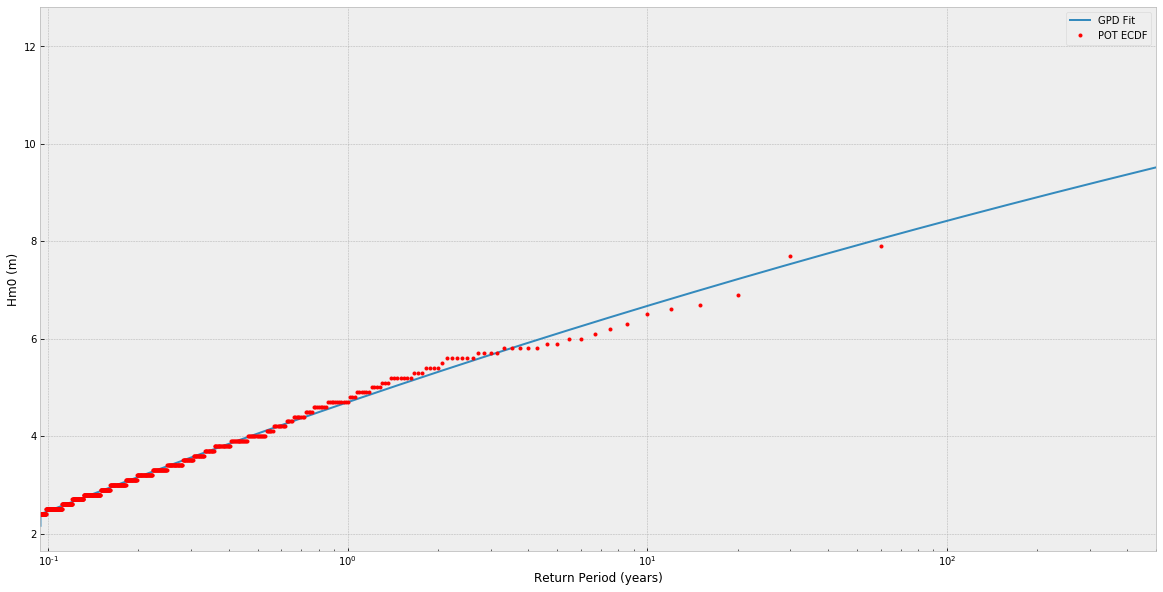

In [41]:
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()
ax.semilogx(y_gpd_rp, x_gpd)
ax.semilogx(ecdf_pot_hor_rp, ecdf_pot_hor_rp.index, '.r')
plt.xlim(0, 500)
plt.xlabel('Return Period (years)')
plt.ylabel('Hm0 (m)')
ax.legend(['GPD Fit', 'POT ECDF'])
plt.show()

## Method 2: Fit peaks over threshold to Generalized Pareto Distribution using (Coles et al. 2001) formula

In [42]:
# Fit POT to Coles-GPD
(param, x_gpd_coles, _,
 y_gpd_rp_coles) = extremal.extremal_distribution_fit(data=data_simar, var_name='Hm0', sample=peaks_over_thres,
                                                      threshold=threshold, fit_type='coles',
                                                      x_min=0.90*min(peaks_over_thres),
                                                      x_max=1.5*max(peaks_over_thres),
                                                      n_points=1000,
                                                      cumulative=True)

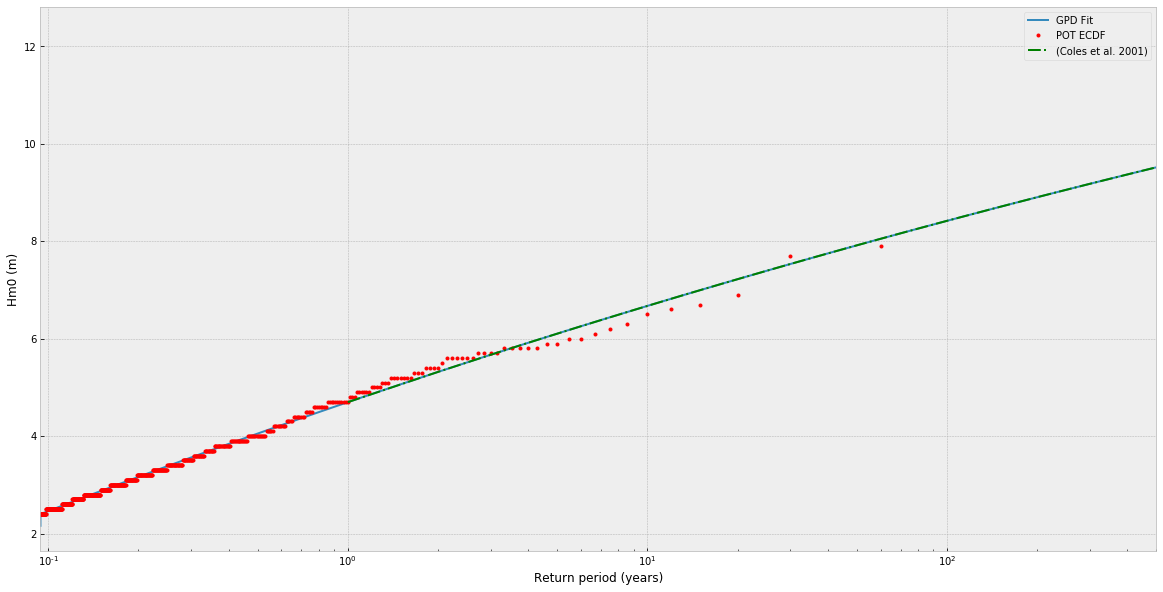

In [43]:
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()
ax.semilogx(y_gpd_rp, x_gpd)
ax.semilogx(ecdf_pot_hor_rp, ecdf_pot_hor_rp.index, 'r.')
ax.semilogx(x_gpd_coles, y_gpd_rp_coles , '-.g')
plt.xlim(0, 500)
plt.xlabel('Return period (years)')
plt.ylabel('Hm0 (m)')
ax.legend(['GPD Fit', 'POT ECDF', '(Coles et al. 2001)'])
plt.show()

## Method 3: Fit GEV to Annual maxima

In [44]:
# Calculation of the annual maxima sample
annual_maxima = extremal.annual_maxima_calculation(data_simar[data_column])

In [45]:
# Fit Annual Maxima to GEV
(param, x_gev, y_gev,
 y_gev_rp) = extremal.extremal_distribution_fit(data=data_simar, var_name='Hm0', sample=annual_maxima,
                                                threshold=None, fit_type='gev',
                                                x_min=0.90*min(annual_maxima),
                                                x_max=1.5*max(annual_maxima),
                                                n_points=1000,
                                                cumulative=True)

C:\Users\GDFA-JUAN\Anaconda2\lib\site-packages\scipy\stats\_continuous_distns.py:1902: RuntimeWarning: invalid value encountered in true_divide
  np.sign(c)*(-g3+(g2+2*g2mg12)*g1)/((g2mg12)**(3./2.)))
C:\Users\GDFA-JUAN\Anaconda2\lib\site-packages\scipy\stats\_continuous_distns.py:1907: RuntimeWarning: invalid value encountered in true_divide
  (g4+(-4*g3+3*(g2+g2mg12)*g1)*g1)/((g2mg12)**2))


In [46]:
# Annual Maxima Empirical distribution
ecdf_am = empirical_distributions.ecdf_histogram(annual_maxima)
ecdf_am_rp = extremal.return_period_curve(1, ecdf_am)

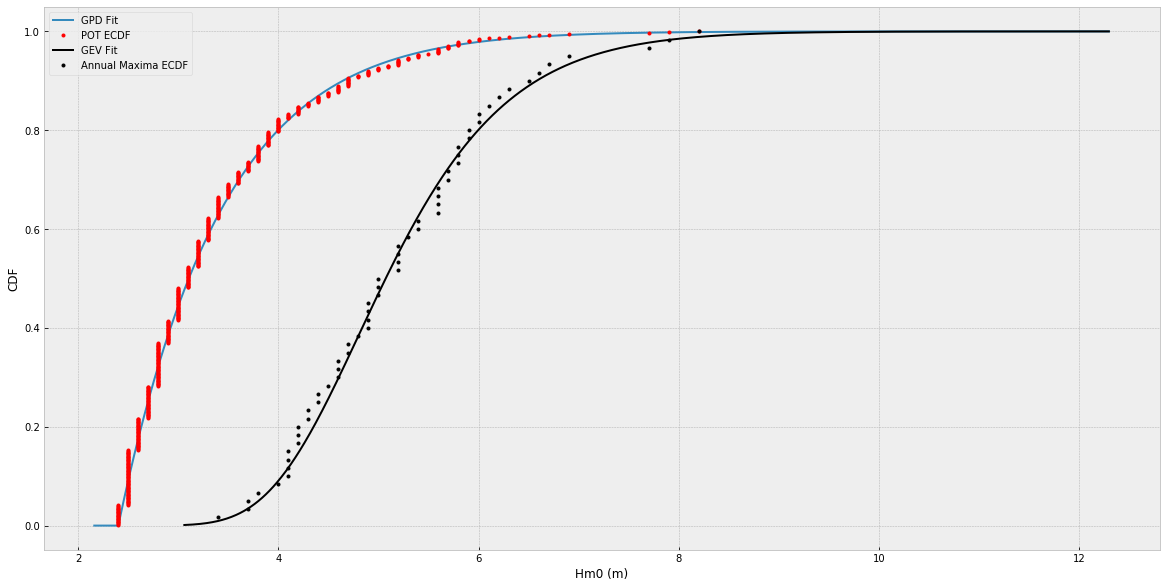

In [47]:
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()
ax.plot(x_gpd, y_gpd)
ax.plot(ecdf_pot.index, ecdf_pot, 'r.')
ax.plot(x_gev, y_gev, 'k')
ax.plot(ecdf_am.index, ecdf_am, '.k')
plt.xlabel('Hm0 (m)')
plt.ylabel('CDF')
ax.legend(['GPD Fit', 'POT ECDF', 'GEV Fit', 'Annual Maxima ECDF'])
plt.show()

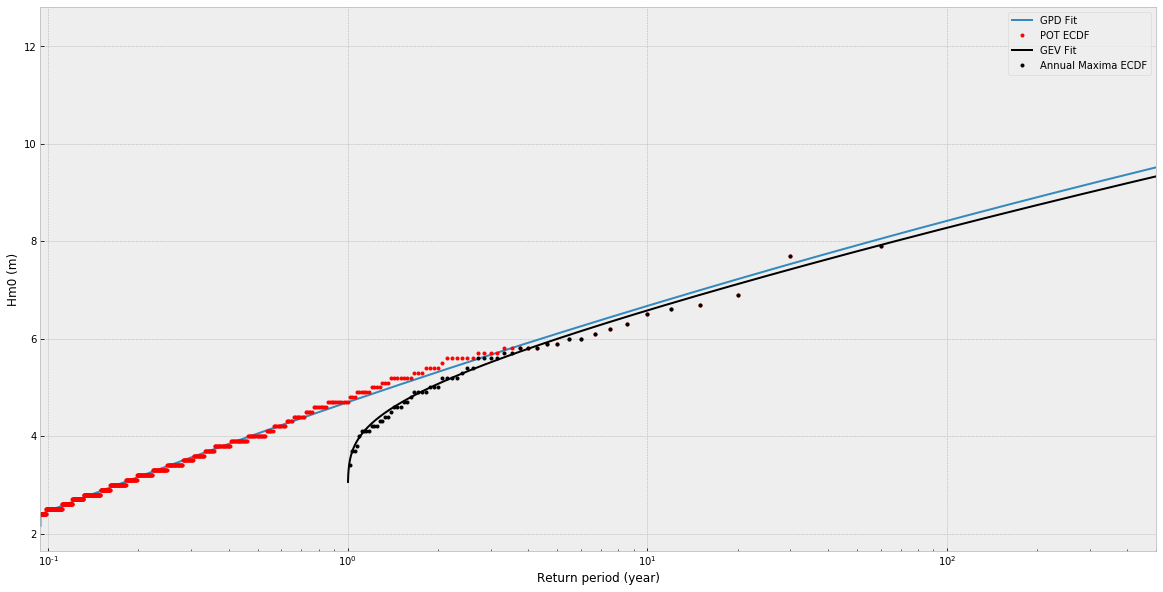

In [48]:
plt.figure(figsize=(fig_x_size,fig_y_size))
ax = plt.axes()
ax.semilogx(y_gpd_rp, x_gpd)
ax.semilogx(ecdf_pot_hor_rp, ecdf_pot_hor_rp.index, 'r.')
ax.semilogx(y_gev_rp, x_gev, 'k')
ax.semilogx(ecdf_am_rp, ecdf_am_rp.index, 'k.')
plt.xlim(0, 500)
plt.xlabel('Return period (year)')
plt.ylabel('Hm0 (m)')
ax.legend(['GPD Fit', 'POT ECDF', 'GEV Fit', 'Annual Maxima ECDF'])
plt.show()

## Verification of the theretical fit distribution (visual)

In [49]:
# Estimation of the GPD parameters
(param, x_gpd, y_gpd, y_gpd_rp) = extremal.extremal_distribution_fit(data=data_simar, var_name='Hm0',
                                                                     sample=peaks_over_thres,
                                                                     threshold=threshold, fit_type='gpd',
                                                                     x_min=0.90*min(peaks_over_thres),
                                                                     x_max=1.5*max(peaks_over_thres),
                                                                     n_points=1000,
                                                                     cumulative=True)

In [50]:
probplot = sm.ProbPlot(peaks_over_thres, dist=genpareto, fit=False, distargs=(param[0], ), loc=param[1], scale=param[2])

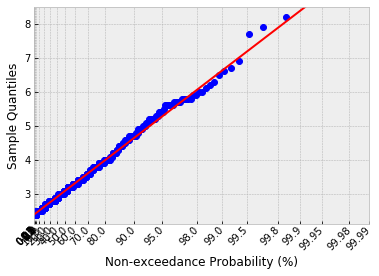

In [51]:
ax = plt.axes()
probplot.probplot(line='45', ax=ax)
plt.show()

## Verification of the theretical fit distribution (Kolmogorov-Smirnov(KS) test)

In [52]:
kstest_genpareto = kstest(rvs=peaks_over_thres.values, cdf='genpareto', args=tuple(param))
kstest_genpareto

KstestResult(statistic=0.059970422914895835, pvalue=0.01962761135044011)